# Shortest path with time constraints and lagrangian relaxation

![title](img/ej9.png)

1. For #EX11 and T ≤ 8 hs. apply the Lagrangian Relaxation method and find a solution iterating for different values of lagrangian multipliers (λ) between 0 and 1.
1. Plot all the objective function primal solutions for the set of lagrangian multipliers used in 1).
1. What should be the optimum λ related to the shortest path solution?

# Import modules and libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog

import matplotlib.pyplot as plt

from mis_utils import *

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.latex.repr = True

## Set connections and get matrices

In [2]:
# Definiciones de constantes

node_names = np.array(('s', '2','3', '4', '5', 't'))

NN_dist = np.zeros((node_names.shape[0], node_names.shape[0]))
NN_time = np.zeros((node_names.shape[0], node_names.shape[0]))

# b = np.zeros((node_names.shape))
beq = np.zeros((node_names.shape))
beq[0]=1
beq[-1]=-1
T1 = 9
T2 = 8

In [3]:
connect_nodes(NN_dist, node_names, 's', '2', 2)
connect_nodes(NN_time, node_names, 's', '2', 3)

connect_nodes(NN_dist, node_names, '2', '4', 2)
connect_nodes(NN_time, node_names, '2', '4', 3)

connect_nodes(NN_dist, node_names, '4', 't', 1)
connect_nodes(NN_time, node_names, '4', 't', 3)

connect_nodes(NN_dist, node_names, '2', 't', 5)
connect_nodes(NN_time, node_names, '2', 't', 1)

connect_nodes(NN_dist, node_names, 's', '3', 1)
connect_nodes(NN_time, node_names, 's', '3', 1)

connect_nodes(NN_dist, node_names, '3', '5', 2)
connect_nodes(NN_time, node_names, '3', '5', 3)

connect_nodes(NN_dist, node_names, '5', 't', 2)
connect_nodes(NN_time, node_names, '5', 't', 5)

In [4]:
NN = ((NN_dist!=0) | (NN_time!=0)!=0).astype(int)
pd.DataFrame((NN!=0).astype(int), columns=node_names, index=node_names)

,s,2,3,4,5,t
s,0,1,1,0,0,0
2,0,0,0,1,0,1
3,0,0,0,0,1,0
4,0,0,0,0,0,1
5,0,0,0,0,0,1
t,0,0,0,0,0,0


In [5]:
print("They are {} connections".format((NN!=0).astype(int).sum().sum()))

They are 7 connections


## Convert to solvable data

In [6]:
Aeq, arc_idxs = nn2na(NN_dist, node_names = node_names, show_results = False)

nan_names = get_col_names(NN, node_names, as_numpy=True, sep = "->")

print("Aeq:")
display(pd.DataFrame(Aeq, index=node_names, columns=nan_names))

Aeq:


,s->2,s->3,2->4,2->t,3->5,4->t,5->t
s,1,1,0,0,0,0,0
2,-1,0,1,1,0,0,0
3,0,-1,0,0,1,0,0
4,0,0,-1,0,0,1,0
5,0,0,0,0,-1,0,1
t,0,0,0,-1,0,-1,-1


In [7]:
t = get_costs(NN_time, arc_idxs)
display(pd.DataFrame([t], index=['t'], columns=nan_names))
costs = get_costs(NN_dist, arc_idxs)
display(pd.DataFrame([costs], index=['C'], columns=nan_names))

,s->2,s->3,2->4,2->t,3->5,4->t,5->t
t,3.0,1.0,3.0,1.0,3.0,3.0,5.0


,s->2,s->3,2->4,2->t,3->5,4->t,5->t
C,2.0,1.0,2.0,5.0,2.0,1.0,2.0


In [8]:
bounds = tuple([(0, None) for arcs in range(0, nan_names.shape[0])])

In [9]:
resume_df = pd.DataFrame(bounds, index=nan_names, columns=['Min bound', 'Max bound'])
resume_df['Costs'] = costs
resume_df['Max time'] = t
resume_df

,Min bound,Max bound,Costs,Max time
s->2,0,None,2.0,3.0
s->3,0,None,1.0,1.0
2->4,0,None,2.0,3.0
2->t,0,None,5.0,1.0
3->5,0,None,2.0,3.0
4->t,0,None,1.0,3.0
5->t,0,None,2.0,5.0


In [10]:
def get_new_cost(cost, t, lamb):
    c_new = np.zeros(cost.shape)
    return cost + lamb*t

In [11]:
# Recomienda usar elmétodo method="revised simplex"

In [12]:
Aeq

array([[ 1,  1,  0,  0,  0,  0,  0],
       [-1,  0,  1,  1,  0,  0,  0],
       [ 0, -1,  0,  0,  1,  0,  0],
       [ 0,  0, -1,  0,  0,  1,  0],
       [ 0,  0,  0,  0, -1,  0,  1],
       [ 0,  0,  0, -1,  0, -1, -1]])

In [13]:
beq

array([ 1.,  0.,  0.,  0.,  0., -1.])

In [14]:
lamb_min = 0.0
lamb_max = 1
lamb_step = 0.01

all_lamb = np.arange(lamb_min, lamb_max, lamb_step)

# solutions = pd.DataFrame(index = nan_names)

resultsT1 = np.zeros((all_lamb.shape[0], 4))
resultsT2 = np.zeros((all_lamb.shape[0], 4))


for idx, lamb in enumerate(all_lamb):
    new_cost = get_new_cost(costs, t, lamb)
    res_simplex = linprog(new_cost, A_eq=Aeq, b_eq=beq, bounds=bounds, method='simplex')
#     solutions[str(lamb)] = pd.DataFrame(costs)
#     sol = pd.DataFrame(res_simplex.x, index = nan_names, columns=[str(lamb)[0:4]])
#     display(pd.DataFrame(res_simplex.x, index = nan_names, columns=[str(lamb)]))
    ce_monio = np.dot(new_cost, res_simplex.x)
    
    resultsT1[idx,0] = lamb
    resultsT1[idx,1] = ce_monio - lamb*T1
    resultsT1[idx,2] = np.dot(res_simplex.x, costs)
    resultsT1[idx,3] = np.dot(res_simplex.x, t)
    resultsT2[idx,0] = lamb
    resultsT2[idx,1] = ce_monio - lamb*T2
    resultsT2[idx,2] = np.dot(res_simplex.x, costs)
    resultsT2[idx,3] = np.dot(res_simplex.x, t)

    
    
    
#     if results.shape[0] == 0:
#         results = np.array([lamb, lagrangian])
#     else:
#         results = np.append(results, [np.array(lamb, lagrangian)])
#     solutions[sol.columns] = sol
    

/home/diego/.virtualenvs/OS11/lib/python3.6/site-packages/ipykernel_launcher.py:15: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  from ipykernel import kernelapp as app


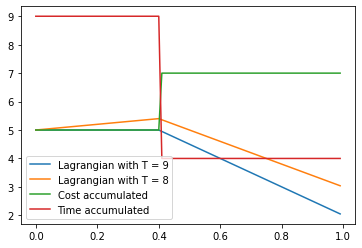

In [15]:
# Todo sucede en torno a 0,4
plt.plot(resultsT1[:,0], resultsT1[:,1])
plt.plot(resultsT2[:,0], resultsT2[:,1])
plt.plot(resultsT2[:,0], resultsT2[:,2])
plt.plot(resultsT2[:,0], resultsT2[:,3])
plt.legend(["Lagrangian with T = 9", "Lagrangian with T = 8", "Cost accumulated", "Time accumulated"])
plt.show()

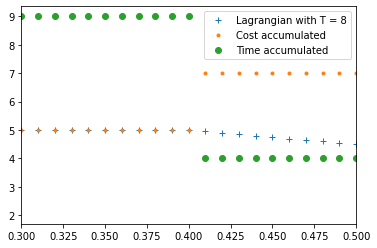

RECORDAR FILTRAR VALORES VÁLIDOS DE lambda


In [16]:
plt.plot(resultsT1[:,0], resultsT1[:,1], '+')
# plt.plot(resultsT2[:,0], resultsT2[:,1], )
plt.plot(resultsT2[:,0], resultsT2[:,2], '.')
plt.plot(resultsT2[:,0], resultsT2[:,3], 'o')
plt.legend(["Lagrangian with T = 8", "Cost accumulated", "Time accumulated"])
plt.xlim(0.3, 0.5)
plt.show()
print("RECORDAR FILTRAR VALORES VÁLIDOS DE lambda")

In [17]:
# resultsT1[:,0][]
# plt.plot(resultsT1[:,0], resultsT1[:,1], '+')
# # plt.plot(resultsT2[:,0], resultsT2[:,1])
# plt.plot(resultsT2[:,0], resultsT2[:,2], '.')
# plt.plot(resultsT2[:,0], resultsT2[:,3], 'o')
# plt.legend(["Lagrangian with T = 8", "Cost accumulated", "Time accumulated"])
# plt.show()

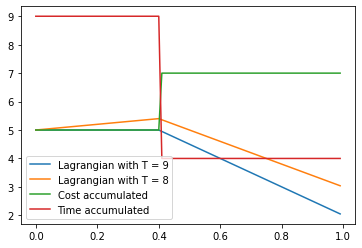

In [18]:
plt.plot(resultsT1[:,0], resultsT1[:,1])
plt.plot(resultsT2[:,0], resultsT2[:,1])
plt.plot(resultsT2[:,0], resultsT2[:,2])
plt.plot(resultsT2[:,0], resultsT2[:,3])
plt.legend(["Lagrangian with T = 9", "Lagrangian with T = 8", "Cost accumulated", "Time accumulated"])
plt.show()

# Solve trough Simplex method for Tmax = 9

In [19]:
# Optimización
res_simplex = linprog(costs, A_eq=Aeq, A_ub = A, b_ub=T1, b_eq=beq, bounds=bounds, method='simplex')

selarcs = get_selected_arcs(res_simplex.x.round().astype(int), nan_names)

NameError: name 'A' is not defined

In [ ]:
pd.DataFrame([res_simplex.x.transpose()], index=['Raw Solutions'], columns=nan_names)

In [ ]:
resume_df['Solution T9'] = res_simplex.x.round().astype(int)

## Show resume for Tmax  = 9

In [ ]:
resume_df['Costo total T9']=resume_df['Costs']*resume_df['Solution T9']
resume_df['Tiempo total T9']=resume_df['Max time']*resume_df['Solution T9']

In [ ]:
print("La ruta detectada es ", selarcs)
print("El costo total es ", resume_df["Costo total T9"].sum())
print("El tiempo total es ", resume_df["Tiempo total T9"].sum())

In [ ]:
np.sum(np.abs(res_simplex.x.round() - res_simplex.x))

In [ ]:
resume_df.transpose()

In [ ]:
res_simplex

# Solve trough Simplex method for Tmax = 8

In [ ]:
# Optimización
res_simplex = linprog(costs, A_eq=Aeq, A_ub = A, b_ub=T2, b_eq=beq, bounds=bounds, method='simplex')

selarcs = get_selected_arcs(res_simplex.x.round().astype(int), nan_names)

In [ ]:
pd.DataFrame([res_simplex.x.transpose()], index=['Raw Solutions'], columns=nan_names)

In [ ]:
resume_df['Solution T8'] = res_simplex.x.round().astype(int)

## Show resume for Tmax  = 8

In [ ]:
resume_df['Costo total T8']=resume_df['Costs']*resume_df['Solution T8']
resume_df['Tiempo total T8']=resume_df['Max time']*resume_df['Solution T8']

In [ ]:
print("La ruta detectada es ", selarcs)
print("El costo total es ", resume_df["Costo total T8"].sum())
print("El tiempo total es ", resume_df["Tiempo total T8"].sum())

In [ ]:
np.sum(np.abs(res_simplex.x.round() - res_simplex.x))

In [ ]:
resume_df.transpose()

# Las conclusiones son que para T=9, lambda debe ser de 0,4, para T=8, lambda debe ser infinitesimalmente superior a 0,4